# Projet SPAM Classifier

Concevoir un classifieur de détection automatique de SPAM.

La collection SMS Spam est un ensemble de messages SMS marqués qui ont été collectés pour la recherche sur les SMS Spam. Elle contient un ensemble de messages SMS en anglais de 5 574 messages, étiquetés selon qu'ils sont ham (légitimes) ou spam.
Rémi vous encourage à vous documenter sur les caractéristiques type des spam et de développer votre stratégie de préparation des données dans ce sens.

En tant que développeur IA, voici les missions :
- Analyse du besoin
- Construction d'un pipeline de ML
- Prétraitement des données
- Entrainement, fine tuning, validation et sélection d'un modèle de classification



In [3]:
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import string
import numpy as np
import re

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.neighbors import KNeighborsClassifier


# Import des donnees

In [5]:
path = os.getcwd() + "/Dataset/SMSSpamCollection"
#path='https://raw.githubusercontent.com/remijul/dataset/refs/heads/master/SMSSpamCollection'
df_ori = pd.read_table(path, sep='\t', header=None, names = ['label','msg'])
#df_ori = pd.read_table(path, sep='\t', header=None, names = ['label','msg'], quoting=csv.QUOTE_NONE)

In [6]:
print(df_ori.shape)
print(df_ori.describe())
print(df_ori.info())

(5572, 2)
       label                     msg
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   msg     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [7]:
# On affiche les premières et dernières lignes
pd.set_option('display.max_colwidth', None)
print(df_ori.head(20))
print(df_ori.tail(20))

   label  \
0    ham   
1    ham   
2   spam   
3    ham   
4    ham   
5   spam   
6    ham   
7    ham   
8   spam   
9   spam   
10   ham   
11  spam   
12  spam   
13   ham   
14   ham   
15  spam   
16   ham   
17   ham   
18   ham   
19  spam   

                                                                                                                                                                                                     msg  
0                                                                                        Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                                                          Ok lar... Joking wif u oni...  
2                                            Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to recei

**Remarque :**  
*On a 5572 entrées au lieu de 5574 prévus dans le dataset.  
Et en vrac... des mots en majuscules, des numéros de téléphone, des liens internet et des messages plus ou moins longs*

In [9]:
# Y-a-t-il des valeurs manquantes ?

print(f"Nb de valeurs nulles dans la colonne spam : {df_ori.label.isnull().sum()}")
print(f"Nb de valeurs nulles dans la colonne msg : {df_ori.msg.isnull().sum()}")

Nb de valeurs nulles dans la colonne spam : 0
Nb de valeurs nulles dans la colonne msg : 0


In [10]:
# J'ai fait fausse route !!! En fait le probleme vient de 3 lignes extraites en une seule à cause de guillemets
# on va rechercher si les mots ham ou spam sont présents dans la colonne msg.
pd.set_option('display.max_colwidth', None)
test = df_ori.msg.str.contains(r'(?:ham|spam)')
df_ori[test]

,label,msg
198,ham,is your hamster dead? Hey so tmr i meet you at 1pm orchard mrt?
291,ham,Hey you told your name to gautham ah?
645,ham,Allo! We have braved the buses and taken on the trains and triumphed. I mean we‘re in b‘ham. Have a jolly good rest of week
869,spam,Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
1193,ham,I was up all night too worrying about this appt. It's a shame we missed a girls night out with quizzes popcorn and you doing my hair.
1488,ham,I told your number to gautham..
1514,ham,Hows the champ just leaving glasgow!
1741,spam,UR GOING 2 BAHAMAS! CallFREEFONE 08081560665 and speak to a live operator to claim either Bahamas cruise of£2000 CASH 18+only. To opt out txt X to 07786200117
2016,ham,Just re read it and I have no shame but tell me how he takes it and if he runs I will blame u 4 ever!! Not really 4 ever just a long time
2318,ham,"Waqt se pehle or naseeb se zyada kisi ko kuch nahi milta,Zindgi wo nahi he jo hum sochte hai Zindgi wo hai jo ham jeetey hai.........."


In [11]:
# On affine notre expression regulière
test = df_ori.msg.str.contains(r'\b(?:ham|spam)\t')
df_ori[test]


,label,msg
5081,ham,"Keep ur problems in ur heart, b'coz nobody will fight for u. Only u &amp; u have to fight for ur self &amp; win the battle. -VIVEKANAND- G 9t.. SD..\nham\tYeah, give me a call if you've got a minute\nham\tHI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VIA ALETTER THATMUM GOTMARRIED 4thNOV.BEHIND OURBACKS  FUCKINNICE!SELFISH,DEVIOUSBITCH.ANYWAY,IL CALL U"""


**Remarque :**  
*On remarque ici que la ligne 5081 comprend 3 lignes. En étudiant les données brutes, on constate que le probleme provient du " (double quotes). 
On peut recharger les données avec l'option quoting=csv.QUOTE_NONE*

In [13]:

import csv
df_ori = pd.read_table(path, sep='\t', header=None, names = ['label','msg'], quoting=csv.QUOTE_NONE)


In [14]:
df_ori.loc[5080:5085]

,label,msg
5080,ham,Mark works tomorrow. He gets out at 5. His work is by your house so he can meet u afterwards.
5081,ham,"""Keep ur problems in ur heart, b'coz nobody will fight for u. Only u &amp; u have to fight for ur self &amp; win the battle. -VIVEKANAND- G 9t.. SD.."
5082,ham,"Yeah, give me a call if you've got a minute"
5083,ham,"""HI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VIA ALETTER THATMUM GOTMARRIED 4thNOV.BEHIND OURBACKS  FUCKINNICE!SELFISH,DEVIOUSBITCH.ANYWAY,IL CALL U"""
5084,ham,Amazing : If you rearrange these letters it gives the same meaning... Dormitory = Dirty room Astronomer = Moon starer The eyes = They see Election results = Lies lets recount Mother-in-law = Woman Hitler Eleven plus two =Twelve plus one Its Amazing... !:-)
5085,ham,Aiya we discuss later lar... Pick ü up at 4 is it?


In [15]:
df_ori.shape

(5574, 2)

**Remarque :**  
*On remarque ici que la ligne 5081 a bien été splittée en 3 lignes [5081, 5082, 5083] et notre dataset a 5574 lignes comme prévu*

# Nettoyage

## Traitement des caractères spéciaux

In [19]:
def list_char_non_alphanum(s):
    caracteres_exclus = string.ascii_letters + string.digits + ' ' + string.punctuation + '£'
    pattern = f"[^{re.escape(caracteres_exclus)}]"
    caracteres_speciaux = re.findall(pattern, s)
    if caracteres_speciaux != []: return caracteres_speciaux

In [20]:
serie_special_char = df_ori.msg.apply(list_char_non_alphanum).dropna()

In [21]:
serie_special_char

18      [, ]
19         [ú]
21         [‘]
22         [ü]
35         [ü]
         ...  
5467       [‘]
5468    [¡, ¡]
5475       [ü]
5513       [‘]
5570       [ü]
Name: msg, Length: 229, dtype: object

In [22]:
list_char_unique = serie_special_char.dropna().explode().unique().tolist()
print(list_char_unique)

['\x92', 'ú', '‘', 'ü', 'Ü', '–', '…', 'è', '\x94', '“', '\x91', '’', '\x93', '\x96', '»', '—', 'é', 'É', 'ì', '鈥', '┾', '〨', '¡']


In [23]:
for i in serie_special_char.index:
        for j in serie_special_char.loc[i]:
            if j in ['ú','ü','Ü']:
                df_ori.loc[i, 'msg'] = df_ori.loc[i, 'msg'].replace(j, "U")
            if j in ['\x92', '\x94', '\x91', '\x93','\x96', '–', '…', '’', "'", '“', '»', '‘', '—', 'è', 'ì', '鈥', '┾', '〨', '¡']:
                df_ori.loc[i, 'msg'] = df_ori.loc[i, 'msg'].replace(j, " ")
            if j in ['é', 'É']:
                df_ori.loc[i, 'msg'] = df_ori.loc[i, 'msg'].replace(j, "a")


In [24]:
df_ori.loc[[18, 22, 5468]]

,label,msg
18,ham,Fine if that s the way u feel. That s the way its gota b
22,ham,So U pay first lar... Then when is da stock comin...
5468,spam,http//tms. widelive.com/index. wml?id=820554ad0a1705572711&first=true C C Ringtone


## Traitement des doublons

In [26]:
doublons_count = df_ori.value_counts() 
mask = pd.DataFrame(doublons_count)['count'] > 1
doublons_count[mask]

label  msg                                                                                                                                                             
ham    Sorry, I'll call later                                                                                                                                              30
       I cant pick the phone right now. Pls send a message                                                                                                                 12
       Ok...                                                                                                                                                               10
       7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st "Ur Lovely Friendship"... good morning dear              4
       Ok.                                                                                                                              

In [27]:
df_no_doublons = df_ori.drop_duplicates()
df_no_doublons.shape

(5170, 2)

In [28]:
print("Nombre de doublons supprimés : ", df_ori.duplicated().sum())

Nombre de doublons supprimés :  404


## Traitement des valeurs manquantes
=> On constate qu'il n'y en a pas

In [30]:
df_no_doublons.isna().value_counts()

label  msg  
False  False    5170
Name: count, dtype: int64

 On a maintenant un dataset clean, on va travailler sur df

In [32]:
df = df_no_doublons.copy()

# Analyse

## Analyse de l'étiquette spam/ham

* Compter le nombre d'occurrences de chaque classe, spam et ham

* Calculer la proportion de chaque classe

Vous pouvez utiliser un graphique pour mieux visualiser la distribution.

Déséquilibre de classes ? Le déséquilibre de classes peut influencer les performances du modèle.

In [36]:
# Compter le nombre d'occurrences de chaque classe
occurrences = df['label'].value_counts()
print(occurrences)

label
ham     4518
spam     652
Name: count, dtype: int64


In [37]:
# Calculer la proportion de chaque classe
proportions = df['label'].value_counts(normalize=True)
print(proportions)

label
ham     0.873888
spam    0.126112
Name: proportion, dtype: float64


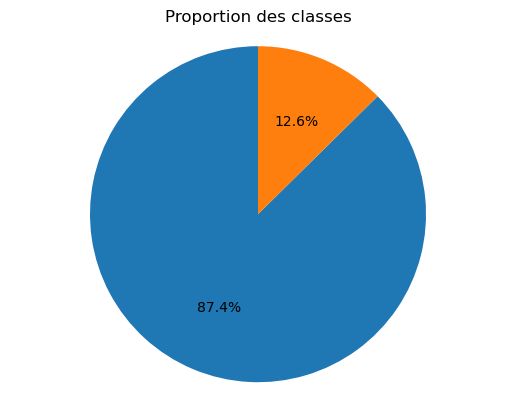

In [38]:
plt.pie(proportions, autopct=lambda p: f'{p:.1f}%', startangle=90)
plt.title('Proportion des classes')
plt.axis('equal')  # Cette ligne assure que le camembert est bien un cercle et non une ellipse
plt.show()

*Il semble effectivement qu'il y ait un déséquilibre d'autant qu'il semble aujourd'hui fréquent de recevoir plus de spams que de messages désirés.*

## Analyse du texte des SMS

* Analyser la longueur des messages : distribution des longueurs pour les messages spam et ham, longueur moyenne, graphique

* Analyser le nombre de mots dans chaque message

In [42]:
def nb_caracteres_msg(msg):
    return len(msg)

def nb_mots_msg(msg):
    return len(msg.split()) #on considère ici un mot entre un ou plusieurs espaces. "you're" est un seul mot

# Nous allons ajouter 2 colonnes à notre dataset avec ces 2 longueurs

df['nb_caracteres'] = df['msg'].apply(nb_caracteres_msg)
df['nb_mots'] = df['msg'].apply(nb_mots_msg)



In [43]:
df.head()

,label,msg,nb_caracteres,nb_mots
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,13


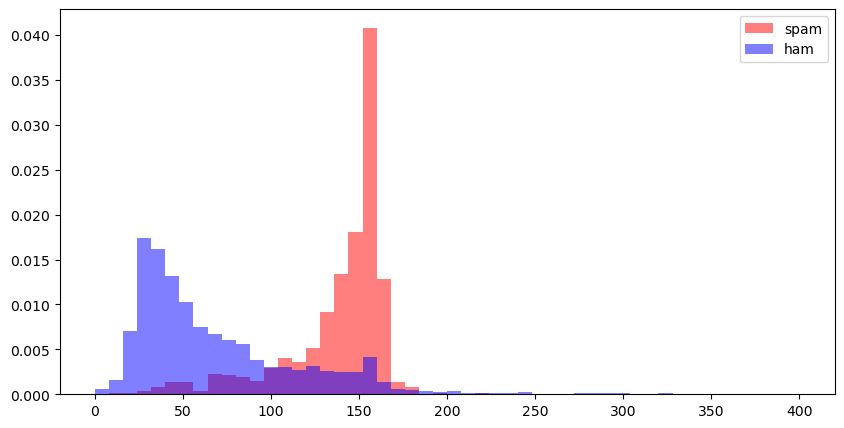

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df[df['label'] == 'spam']['nb_caracteres'], range=(0,400), bins=50, alpha=0.5, label='spam', color='red', density=True)
plt.hist(df[df['label'] == 'ham']['nb_caracteres'], range=(0,400), bins=50,  alpha=0.5, label='ham', color='blue', density=True)
plt.legend(loc='upper right')
plt.show()

In [45]:
ham_nb_moyen_caractères = df[df['label'] == 'ham']['nb_caracteres'].mean()
spam_nb_moyen_caractères = df[df['label'] == 'spam']['nb_caracteres'].mean()
print(f"La longueur moyenne des messages ham est de {round(ham_nb_moyen_caractères, 2)} caractères.")
print(f"La longueur moyenne des messages spam est de {round(spam_nb_moyen_caractères, 2)} caractères.")

La longueur moyenne des messages ham est de 70.89 caractères.
La longueur moyenne des messages spam est de 137.71 caractères.


**On regarde maintenant en nombre de mots**

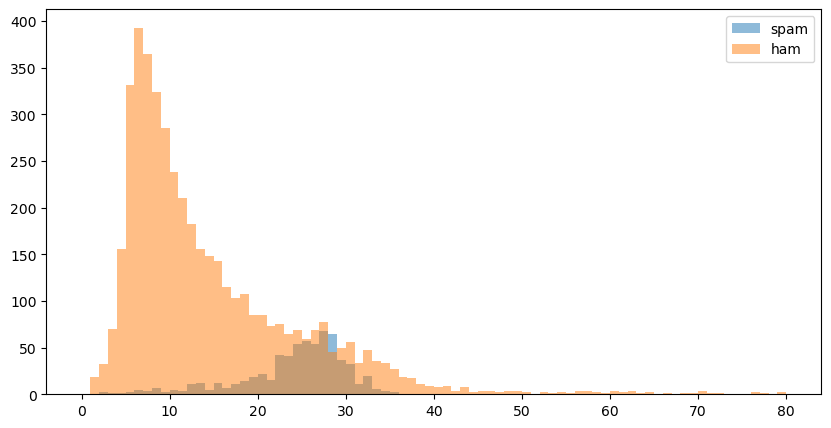

In [47]:
plt.figure(figsize=(10,5))
plt.hist(df[df['label'] == 'spam']['nb_mots'], range=(0,80), bins=80, alpha=0.5, label='spam')
plt.hist(df[df['label'] == 'ham']['nb_mots'], range=(0,80), bins=80, alpha=0.5, label='ham')
plt.legend(loc='upper right')
plt.show()

In [48]:
ham_nb_moyen_mots = df[df['label'] == 'ham']['nb_mots'].mean()
spam_nb_moyen_mots = df[df['label'] == 'spam']['nb_mots'].mean()
print(f"La longueur moyenne des messages ham est de {round(ham_nb_moyen_mots, 2)} mots.")
print(f"La longueur moyenne des messages spam est de {round(spam_nb_moyen_mots, 2)} mots.")

La longueur moyenne des messages ham est de 14.25 mots.
La longueur moyenne des messages spam est de 23.74 mots.


In [49]:
#Plus synthetiquement...
df.groupby('label')['nb_caracteres'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4518.0,70.894865,56.590179,2.0,34.0,53.0,91.0,910.0
spam,652.0,137.710123,29.841831,13.0,132.0,148.0,157.0,223.0


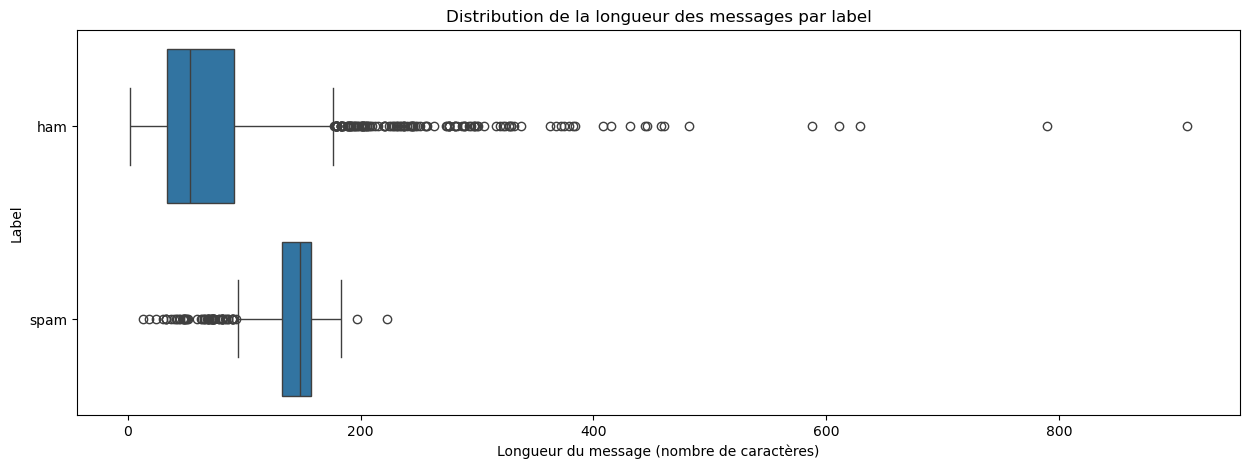

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(15, 5))

# Création du boxplot avec Seaborn
# orient='h' : orientation horizontale du boxplot
# ax=ax : indique à Seaborn d'utiliser les axes 'ax' que nous avons créés
sns.boxplot(x='nb_caracteres', y='label', data=df, orient='h', ax=ax)

ax.set_title('Distribution de la longueur des messages par label')
ax.set_xlabel('Longueur du message (nombre de caractères)')
ax.set_ylabel('Label')

plt.show()

## Analyse de la frequence des chiffres

In [52]:
# On va faire une analyse de la frequence des chiffres
import re

def contient_chiffre(text):
    return bool(re.search(r"\d", text))

# On crée une colonne 'chiffres' de booleens
df['chiffres'] = df['msg'].apply(contient_chiffre)

In [53]:
df.groupby('label')['chiffres'].value_counts()

label  chiffres
ham    False       3803
       True         715
spam   True         613
       False         39
Name: count, dtype: int64

In [54]:
proportions = df.groupby('label')['chiffres'].value_counts(normalize=True).unstack()
proportions

chiffres,False,True
label,,
ham,0.841744,0.158256
spam,0.059816,0.940184


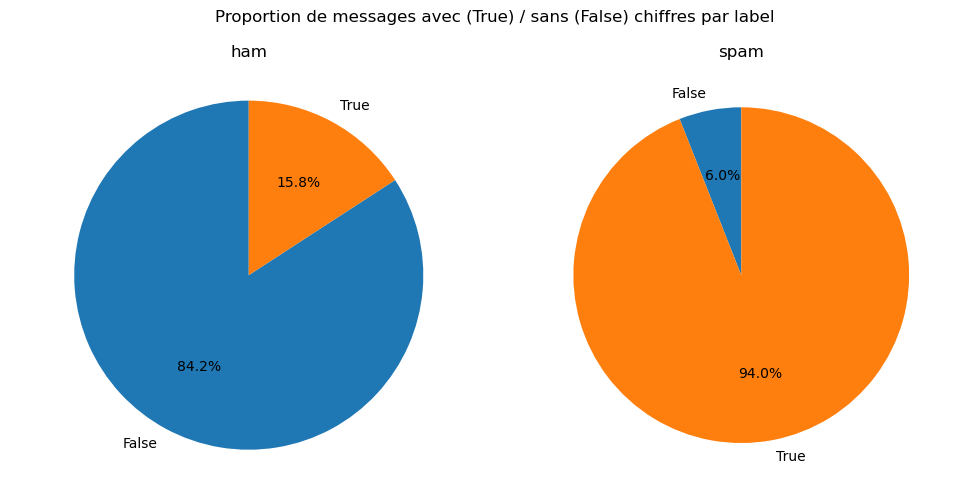

In [55]:
def display_percentage(p):
    return f'{p:.1f}%'



fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes de graphiques

# Camembert pour les messages 'ham'
axes[0].pie(proportions.loc['ham'].values, labels=proportions.loc['ham'].index, autopct=display_percentage, startangle=90)
axes[0].set_title('ham')
axes[0].axis('equal')

# Camembert pour les messages 'spam'
axes[1].pie(proportions.loc['spam'].values, labels=proportions.loc['ham'].index, autopct=display_percentage, startangle=90)
axes[1].set_title('spam')
axes[0].axis('equal')

# Titre global et ajustement de la mise en page
fig.suptitle('Proportion de messages avec (True) / sans (False) chiffres par label')
plt.tight_layout()
plt.show()

# Modeles ML

## Premiers tests rapides CountVectorizer et SVC

In [58]:
# Vectorisation
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['msg'])
vectorizer.get_feature_names_out()
print(X.toarray().shape)
print(X.toarray())

(5170, 8712)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [59]:
 # Split du dataset : train & test

from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(
X, df['label'], test_size=0.20, random_state=1)

In [60]:
#Test SVC
my_SVCmodel = SVC(kernel = 'linear', C = 1).fit(features_train, labels_train)
my_SVCmodel_predictions = my_SVCmodel.predict(features_train)
accuracy= my_SVCmodel.score(features_train, labels_train)
print("Précision entrainement:",accuracy)


Précision entrainement: 0.9997582205029013


In [61]:
my_SVCmodel_predictions = my_SVCmodel.predict(features_test)
accuracy= my_SVCmodel.score(features_test, labels_test)
print("Précision du test:",accuracy)

Précision du test: 0.9845261121856866


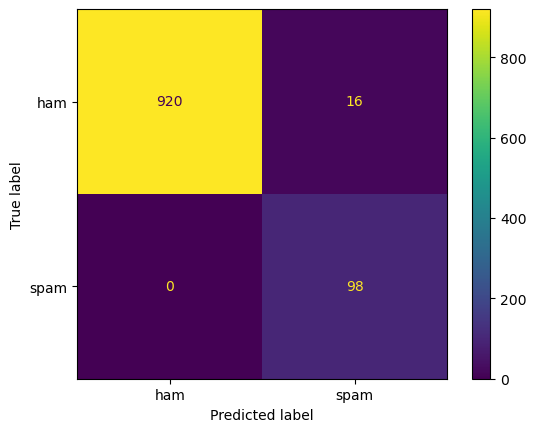

In [62]:
cm = confusion_matrix(my_SVCmodel_predictions, labels_test)
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()

In [63]:
 # On va tester la taille des set test et train avec une variation de 5%
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['msg'])

for size in range(10, 90, 5):
  print("taille de l'echantillon de test : ",size/100)
  features_train, features_test, labels_train, labels_test = train_test_split(
X, df['label'], test_size=size/100, random_state=1)

  print("feature_test : ",features_test.shape)
  print(labels_test.value_counts(normalize=True))
  print("feature_train : ",features_train.shape)
  print(labels_train.value_counts(normalize=True))


  my_SVCmodel = SVC(kernel = 'linear', C = 2).fit(features_train, labels_train)
  my_SVCmodel_predictions = my_SVCmodel.predict(features_train)
  accuracy_train= my_SVCmodel.score(features_train, labels_train)
  my_SVCmodel_predictions = my_SVCmodel.predict(features_test)
  accuracy_test= my_SVCmodel.score(features_test, labels_test)
  print(f"Précision entrainement : {accuracy_train} Précision du test : {accuracy_test}")
  cm = confusion_matrix(my_SVCmodel_predictions, labels_test)
  print(cm)
  print()

taille de l'echantillon de test :  0.1
feature_test :  (517, 8712)
label
ham     0.903288
spam    0.096712
Name: proportion, dtype: float64
feature_train :  (4653, 8712)
label
ham     0.870621
spam    0.129379
Name: proportion, dtype: float64
Précision entrainement : 1.0 Précision du test : 0.9903288201160542
[[467   5]
 [  0  45]]

taille de l'echantillon de test :  0.15
feature_test :  (776, 8712)
label
ham     0.903351
spam    0.096649
Name: proportion, dtype: float64
feature_train :  (4394, 8712)
label
ham     0.868685
spam    0.131315
Name: proportion, dtype: float64
Précision entrainement : 1.0 Précision du test : 0.9871134020618557
[[700   9]
 [  1  66]]

taille de l'echantillon de test :  0.2
feature_test :  (1034, 8712)
label
ham     0.889749
spam    0.110251
Name: proportion, dtype: float64
feature_train :  (4136, 8712)
label
ham     0.869923
spam    0.130077
Name: proportion, dtype: float64
Précision entrainement : 1.0 Précision du test : 0.9845261121856866
[[920  16]
 [  0 

**Remarque :**  
*Plus la taille de l'ehcantillon d'entrainement est grande plus grande est la precision mais je pense que c'est dû à un surentrainement. Dans le doute je me conforme aux valeurs usuelles du train_test_split avec un test_size de 20%.*

## Utilisation des pipelines

In [66]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC


from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [67]:
# Dataset split

lb = LabelBinarizer()

y = lb.fit_transform(df.label)
X = df.msg

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [68]:
model = make_pipeline(CountVectorizer(),
                      SVC(kernel = 'linear', C = 1))
model

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('svc', SVC(C=1, kernel='linear'))])

In [69]:
model.fit(X_train, y_train.ravel())

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('svc', SVC(C=1, kernel='linear'))])

In [70]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [71]:
model.score(X_train, y_train)


0.9997582205029013

In [72]:
model.score(X_test, y_test)


0.9816247582205029

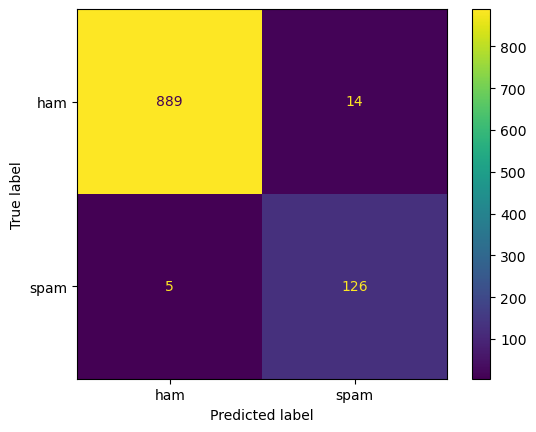

In [73]:
cm = confusion_matrix(model.predict(X_test), y_test)
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
    

## Faisons varier mes parametres avec GridSearchCV

In [75]:
from sklearn.model_selection import GridSearchCV

In [76]:
param_grid = {'svc__C' : np.arange(0.1 , 2.0 , 0.1)
             }
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('svc', SVC(C=1, kernel='linear'))]),
             param_grid={'svc__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])})

In [77]:
grid.best_score_


0.9818662414056977

In [78]:
grid.best_params_

{'svc__C': 0.2}

0.9990328820116054
0.9835589941972921


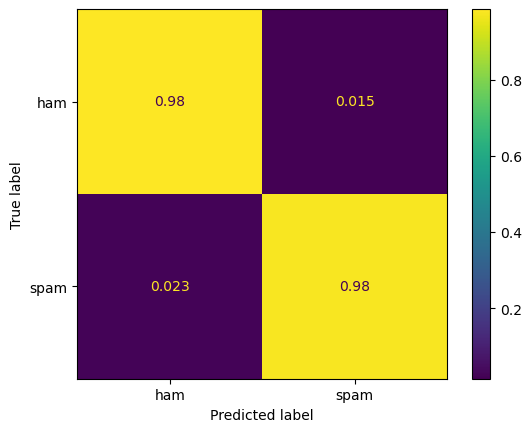

In [79]:
model = make_pipeline(CountVectorizer(),
                      SVC(kernel = 'linear', C = 0.2))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()

**Remarque :**  
*Pour le SVC, la meilleure valeur de C varie selon le random state uilisé lors du train split. On va choisir arbitrairement C=0,2*

# On va essayer d'autres type d'extracteurs

## HashingVectorizer

0.9770309477756286
0.971953578336557


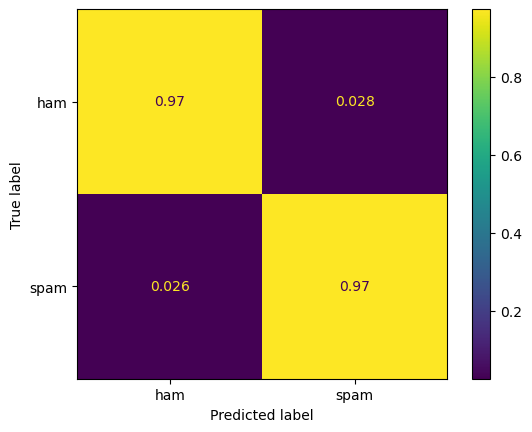

In [83]:
model = make_pipeline(HashingVectorizer(),
                      SVC(kernel = 'linear', C = 0.2))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()

In [84]:
param_grid = {'hashingvectorizer__n_features' : np.arange(500 , 6000 , 500)
             }
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('hashingvectorizer',
                                        HashingVectorizer()),
                                       ('svc', SVC(C=0.2, kernel='linear'))]),
             param_grid={'hashingvectorizer__n_features': array([ 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500])})

In [85]:
grid.best_score_


0.9642161587485176

In [86]:
grid.best_params_

{'hashingvectorizer__n_features': 5000}

## TfidVectorizer

0.9748549323017408
0.9709864603481625


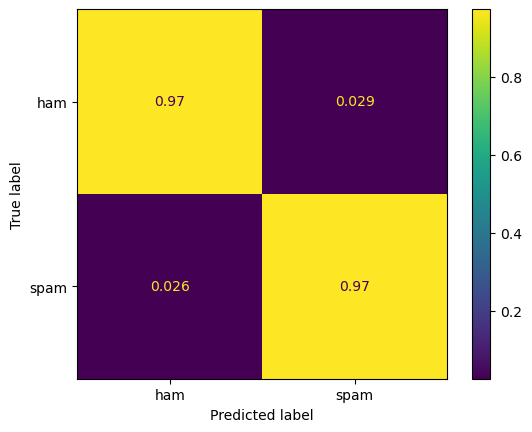

In [88]:
model = make_pipeline(TfidfVectorizer(),
                      SVC(kernel = 'linear', C = 0.2))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()

**Remarque :**  
*Apres plusieurs tests sur les features extracteurs, le countVectorizer semble offrir les meilleures performances pour notre SVC*

# Essayons d'autres classifiers
et ajoutons-y des metriques avec classification_report

## KNN classifier

0.9248065764023211
0.9148936170212766
              precision    recall  f1-score   support

         ham       0.91      1.00      0.95       894
        spam       1.00      0.37      0.54       140

    accuracy                           0.91      1034
   macro avg       0.96      0.69      0.75      1034
weighted avg       0.92      0.91      0.90      1034



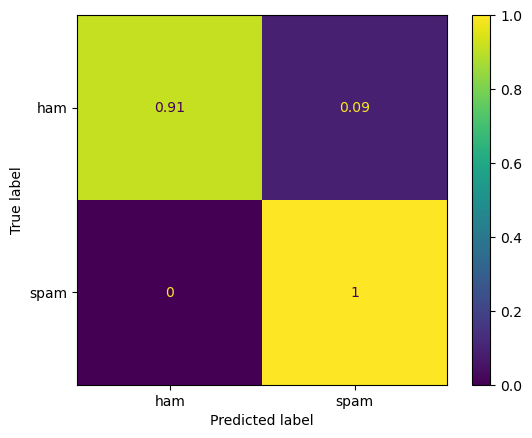

In [92]:
from sklearn.neighbors import KNeighborsClassifier

model = make_pipeline(CountVectorizer(),
                      KNeighborsClassifier(n_neighbors=5))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

### GridSearchCV sur les parametres de notre KNN


In [94]:
param_grid = {'kneighborsclassifier__n_neighbors' : [25, 70],#np.arange(39, 80 , 1),
              'kneighborsclassifier__metric' : ['euclidean', 'cityblock', 'cosine', 'manhattan'],
              #'kneighborsclassifier__algorithm' : ['ball_tree', 'kd_tree' ]
             }
grid = GridSearchCV(model, param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train, y_train.ravel())
print(grid.best_score_)
print(grid.best_params_)

0.9708352731115882
{'kneighborsclassifier__metric': 'cosine', 'kneighborsclassifier__n_neighbors': 70}


0.9373791102514507
0.9313346228239845
              precision    recall  f1-score   support

         ham       0.93      1.00      0.96       894
        spam       1.00      0.49      0.66       140

    accuracy                           0.93      1034
   macro avg       0.96      0.75      0.81      1034
weighted avg       0.94      0.93      0.92      1034



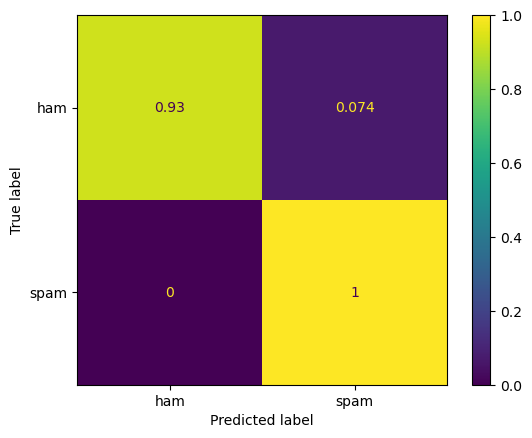

In [95]:
model = make_pipeline(CountVectorizer(),
                      KNeighborsClassifier(metric = 'cosine', n_neighbors=70))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

0.9828336557059961
0.965183752417795
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       894
        spam       0.96      0.78      0.86       140

    accuracy                           0.97      1034
   macro avg       0.96      0.89      0.92      1034
weighted avg       0.96      0.97      0.96      1034



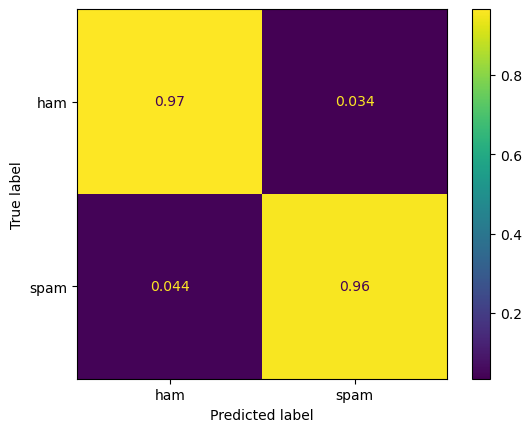

In [96]:
model = make_pipeline(CountVectorizer(),
                      KNeighborsClassifier(metric = 'cosine', n_neighbors=3))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

In [97]:
grid.scorer_


make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba'))

On refait les tests avec le scorer 'roc_auc'

In [99]:
model = make_pipeline(CountVectorizer(),
                      SVC(kernel = 'linear', C = 1))
param_grid = {'svc__C' : np.arange(0.1 , 2.0 , 0.1)
             }
grid = GridSearchCV(model, param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train, y_train.ravel())
print(grid.best_score_)
print(grid.best_params_)

0.9897098927621106
{'svc__C': 0.1}


In [100]:
grid.scorer_


make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba'))

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=14)

0.9990328820116054
0.9835589941972921
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       904
        spam       0.99      0.88      0.93       130

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



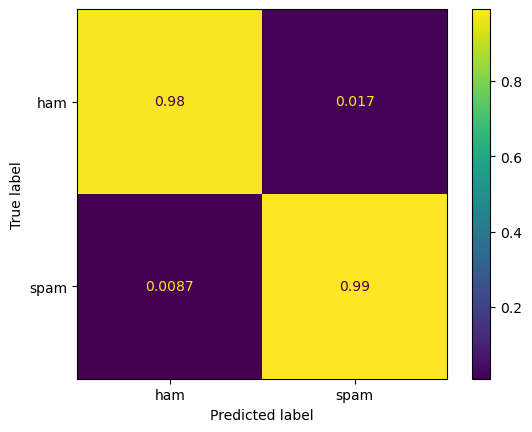

In [102]:
model = make_pipeline(CountVectorizer(),
                      SVC(kernel = 'linear', C = 0.2))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

0.995889748549323
0.9796905222437138
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       904
        spam       0.99      0.85      0.91       130

    accuracy                           0.98      1034
   macro avg       0.98      0.92      0.95      1034
weighted avg       0.98      0.98      0.98      1034



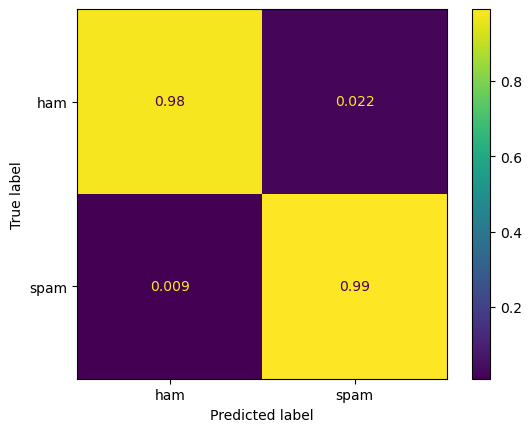

In [103]:
model = make_pipeline(CountVectorizer(),
                      SVC(kernel = 'linear', C = 0.1))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

0.9354448742746615
0.937137330754352
              precision    recall  f1-score   support

         ham       0.93      1.00      0.97       904
        spam       0.99      0.51      0.67       130

    accuracy                           0.94      1034
   macro avg       0.96      0.75      0.82      1034
weighted avg       0.94      0.94      0.93      1034



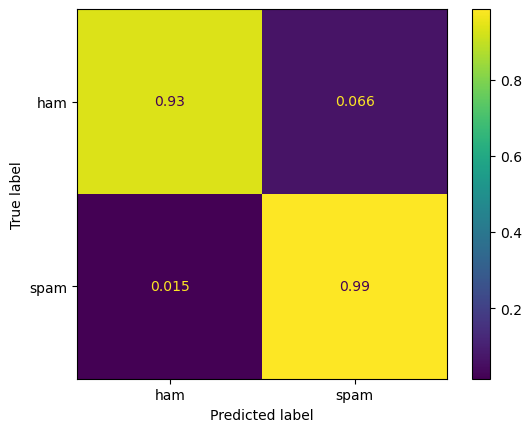

In [104]:
model = make_pipeline(CountVectorizer(),
                      KNeighborsClassifier(metric = 'cosine', n_neighbors=70))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

## MultinomialNB

0.9932301740812379
0.9864603481624759
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       904
        spam       0.98      0.92      0.94       130

    accuracy                           0.99      1034
   macro avg       0.98      0.96      0.97      1034
weighted avg       0.99      0.99      0.99      1034



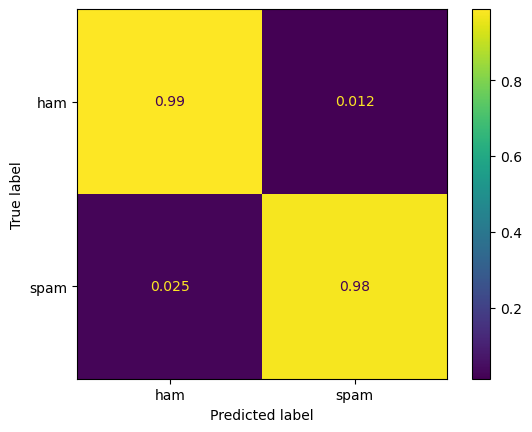

In [106]:
from sklearn.naive_bayes import MultinomialNB

model = make_pipeline(CountVectorizer(),
                      MultinomialNB())
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

## MultinomialNB + CountVectorizer(stop_words='english')

0.9956479690522244
0.9845261121856866
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       904
        spam       0.97      0.91      0.94       130

    accuracy                           0.98      1034
   macro avg       0.98      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034



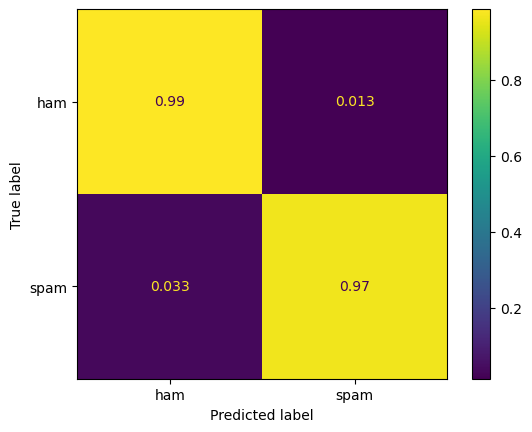

In [108]:
from sklearn.naive_bayes import MultinomialNB

model = make_pipeline(CountVectorizer(stop_words='english'),
                      MultinomialNB())
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

## SVC + CountVectorizer(stop_words='english')

0.9975822050290135
0.9787234042553191
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       904
        spam       1.00      0.83      0.91       130

    accuracy                           0.98      1034
   macro avg       0.99      0.92      0.95      1034
weighted avg       0.98      0.98      0.98      1034



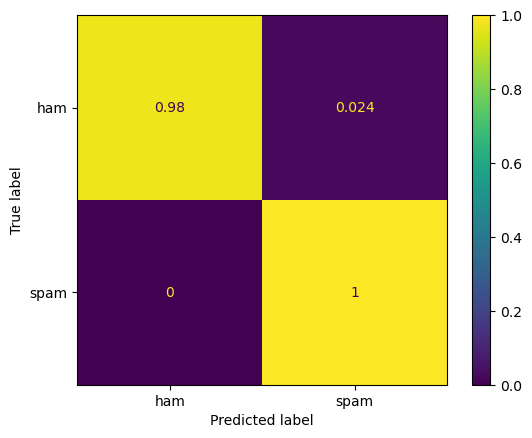

In [110]:
model = make_pipeline(CountVectorizer(stop_words='english'),
                      SVC(kernel = 'linear', C = 0.2))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

## SVC + CountVectorizer(stop_words='english', ngram_range=(2,2))

0.9975822050290135
0.9535783365570599
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       904
        spam       1.00      0.63      0.77       130

    accuracy                           0.95      1034
   macro avg       0.97      0.82      0.87      1034
weighted avg       0.96      0.95      0.95      1034



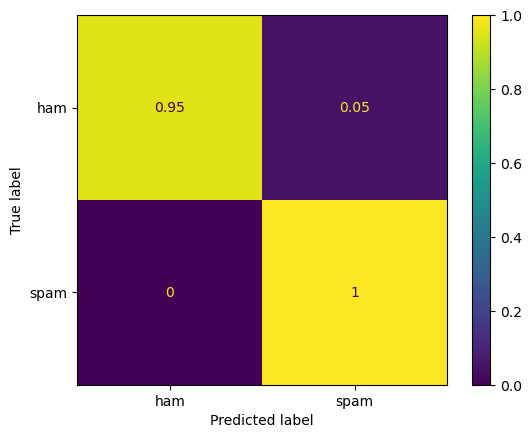

In [112]:
model = make_pipeline(CountVectorizer(analyzer='word', ngram_range=(2, 2), stop_words='english'),
                      SVC(kernel = 'linear', C = 0.2))
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

**Remarque :**  
*En jouant sur les options du CountVectorizer, je ne note aucune amélioration significative. Je vais donc le garder sans aucune option de base et continuer d'essayer de trouver un classifier plus performant.  Par plus performant, j'entends minimiser le nombre de faux négatif ('ham' classé en 'spam') car il me semble que c'est le plus important.*

## SGDClassifier + CountVectorizer

0.9995164410058027
0.9777562862669246
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       904
        spam       0.94      0.88      0.91       130

    accuracy                           0.98      1034
   macro avg       0.96      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



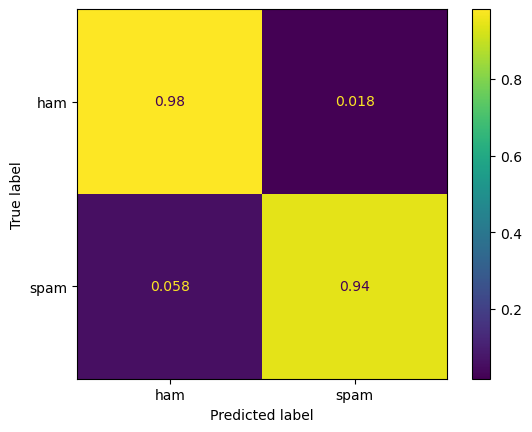

In [115]:
from sklearn.linear_model import SGDClassifier
model = make_pipeline(CountVectorizer(),
                      SGDClassifier())
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

## Perceptron + CountVectorizer

0.9997582205029013
0.9796905222437138
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       904
        spam       0.96      0.88      0.92       130

    accuracy                           0.98      1034
   macro avg       0.97      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



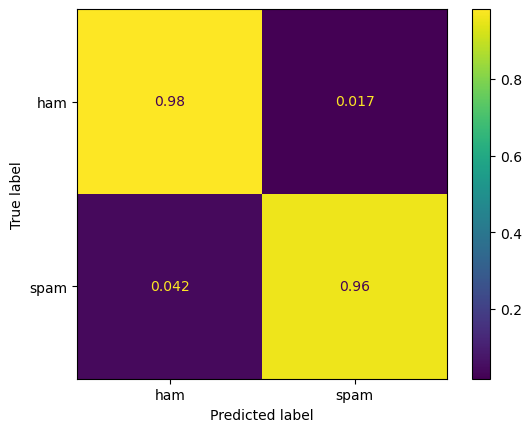

In [117]:
from sklearn.linear_model import Perceptron
model = make_pipeline(CountVectorizer(),
                      Perceptron())
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

## PassiveAggressiveClassifier + CountVectorizer

1.0
0.9845261121856866
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       904
        spam       0.97      0.90      0.94       130

    accuracy                           0.98      1034
   macro avg       0.98      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034



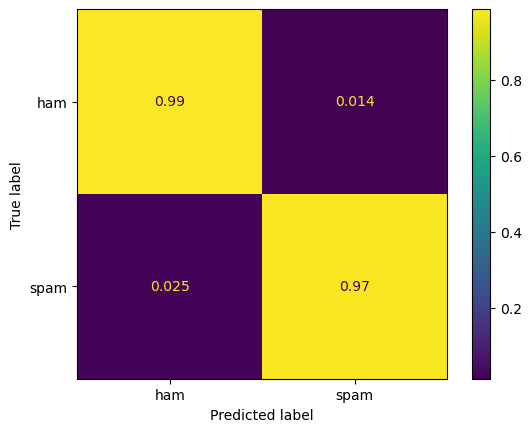

In [119]:
from sklearn.linear_model import PassiveAggressiveClassifier
model = make_pipeline(CountVectorizer(),
                      PassiveAggressiveClassifier())
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
cm = confusion_matrix(model.predict(X_test), y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))

**Conclusion**  
*Certains modeles (KNN) donnent d'excellents resultats sur le nombre de Faux Positif ('spam' classé 'ham') mais ce resutlat ne me semble pas le plus pertinent bien que cela puisse dependre des applications.*  
*Pour le moment le meilleur modèle à mon sens, celui qui minimise le nombre de Faux Négatif (c'est à dire qui classe le moins de ham en spam), est le Bayes Naïf multinomial ci-dessous.* 


0.9932301740812379
0.9864603481624759
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       904
        spam       0.98      0.92      0.94       130

    accuracy                           0.99      1034
   macro avg       0.98      0.96      0.97      1034
weighted avg       0.99      0.99      0.99      1034



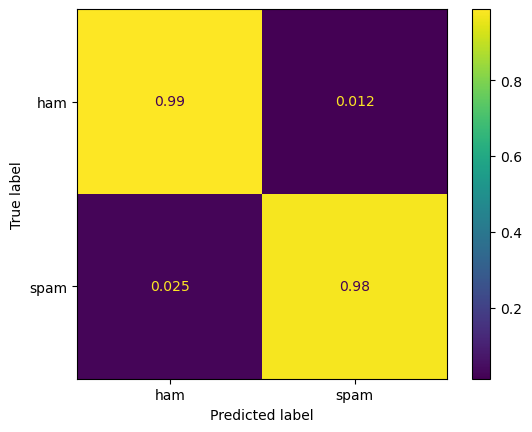

In [121]:
from sklearn.naive_bayes import MultinomialNB

model = make_pipeline(CountVectorizer(),
                      MultinomialNB())
model.fit(X_train, y_train.ravel())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred, y_test, normalize="true")
display = ConfusionMatrixDisplay(cm, display_labels = ['ham', 'spam'])
display.plot()
target_names = ['ham', 'spam']
print(classification_report(y_test, y_pred, target_names=target_names))